# Modeling Hypergraphs of MEDLINE Journals

## Model

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admissible combinations of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Poisson(\lambda_h)$.
* The mean $\lambda_h$ depends on the (latent) features of nodes in $h$: $$\lambda_h=\sum_k\prod_{i\in h}r_i\theta_{ik},$$ where $\theta_{ik}$ is the percentage of node $i$ in block $k$  ($\sum_{k}\theta_{ik}=1$), and $r_i$ corresponds to the popularity of node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$ and $r=(r_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Estimation: Use stochastic gradient descent to estimate $\theta$ and $r$
    * Let $\theta_{ij}=\theta_{ij}r_i$, so that we only need to deal with one set of variables $\theta$.

## Workbench

In [1]:
import time
import pandas as pd
import scipy.sparse as ssp
import numpy as np
from multiprocessing import Pool, cpu_count
from scipy.stats import dirichlet
from collections import Counter
from datetime import datetime
import random
from collections import defaultdict
from scipy.optimize import minimize
from itertools import zip_longest
from numba import guvectorize,vectorize
from numba import int64,float64,int32
from numba import cuda
import math
import pickle as pickle
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve
from functools import partial

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg, flush=True)
        self.start_time=time.time()
    def stop(self,msg=''):
        if msg:
            print("{}: {} seconds".format(msg,time.time()-self.start_time), flush=True)
        else:
            print("Elapsed time: {} seconds".format(time.time()-self.start_time), flush=True)
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Load data

In [7]:
def load_date(filename):
    tic=Stopwatch()
    print("Loading paper dates %s from disk..." % filename),
    tic.go()
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    tic.stop()
    return A

def load_hypergraph(filename):
    tic=Stopwatch()
    print("Loading file %s from disk..." % filename),
    tic.go()
    pkl_file = open(filename, 'rb')
    (row,col) = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562, max(col)+1),dtype=np.int8)
    tic.stop()
    return A

In [8]:
!ls ../data/medline

chemical.pkl   disease.pkl	id2disease.pkl	journals.pkl  paper_dates.pkl
citations.pkl  id2chemical.pkl	id2method.pkl	method.pkl


In [8]:
tic=Stopwatch()
G=load_hypergraph('../data/medline/journals.pkl').tocsr()
paper_dates=load_date('../data/medline/paper_dates.pkl')

Loading file ../data/medline/journals.pkl from disk...
Elapsed time: 89.76556921005249 seconds
Loading paper dates ../data/medline/paper_dates.pkl from disk...
Elapsed time: 2.0460081100463867 seconds


In [9]:
Counter(paper_dates)

Counter({np.int64(-1): 3011366,
         np.int64(2008): 650129,
         np.int64(2007): 627336,
         np.int64(2006): 612750,
         np.int64(2005): 583842,
         np.int64(2004): 557686,
         np.int64(2003): 524728,
         np.int64(2002): 500423,
         np.int64(2001): 479434,
         np.int64(2000): 450871,
         np.int64(2009): 445648,
         np.int64(1999): 423046,
         np.int64(1998): 412126,
         np.int64(1997): 398176,
         np.int64(1996): 389401,
         np.int64(1995): 383192,
         np.int64(1994): 374184,
         np.int64(1993): 364239,
         np.int64(1992): 358775,
         np.int64(1991): 355473,
         np.int64(1990): 354127,
         np.int64(1989): 348124,
         np.int64(1988): 334360,
         np.int64(1987): 317428,
         np.int64(1986): 300651,
         np.int64(1985): 287918,
         np.int64(1984): 279096,
         np.int64(1983): 272964,
         np.int64(1982): 260583,
         np.int64(1979): 251212,
         np

In [29]:
G=G[paper_dates>0,:]
paper_dates=paper_dates[paper_dates>0]
G=G[paper_dates<2010,:]
paper_dates=paper_dates[paper_dates<2010]
paper_dates[paper_dates<1950]=1950

In [30]:
Counter(paper_dates)

Counter({np.int64(2008): 650129,
         np.int64(2007): 627336,
         np.int64(2006): 612750,
         np.int64(2005): 583842,
         np.int64(2004): 557686,
         np.int64(2003): 524728,
         np.int64(2002): 500423,
         np.int64(2001): 479434,
         np.int64(2000): 450871,
         np.int64(2009): 445648,
         np.int64(1999): 423046,
         np.int64(1998): 412126,
         np.int64(1997): 398176,
         np.int64(1996): 389401,
         np.int64(1995): 383192,
         np.int64(1994): 374184,
         np.int64(1993): 364239,
         np.int64(1992): 358775,
         np.int64(1991): 355473,
         np.int64(1990): 354127,
         np.int64(1989): 348124,
         np.int64(1988): 334360,
         np.int64(1987): 317428,
         np.int64(1986): 300651,
         np.int64(1985): 287918,
         np.int64(1984): 279096,
         np.int64(1950): 275828,
         np.int64(1983): 272964,
         np.int64(1982): 260583,
         np.int64(1979): 251212,
         n

## Inference

In [4]:
def get_nodes(e):
    global G0
    return tuple(sorted(G0[e,:].nonzero()[1]))
    
def get_hyperedges():
    # G: a edge-by-node incidence matrix
    global G0
    x=(G0.sum(axis=1).A.flatten()>1).nonzero()[0]
    if len(x)==0:
        return Counter()
    with Pool(cpu_count()-1) as pool:
        E=Counter(pool.map(get_nodes, x))
    return E

def batch_generator(iterable, batchsize, shuffle=False):
    if shuffle:
        iterable=list(iterable)
        random.shuffle(iterable)
    sentinel=object()
    return ([entry for entry in i if entry is not sentinel]
            for i in zip_longest(*([iter(iterable)]*batchsize), fillvalue=sentinel))

In [4]:
import numpy as np
from collections import Counter
from multiprocessing import Pool, cpu_count
from functools import partial

def get_nodes(e, G0):
    # Convert sparse row to dense array and get non-zero indices
    dense_row = G0[e, :].toarray().flatten()
    return tuple(sorted(np.nonzero(dense_row)[0]))

def worker_function(e, G0):
    # This function is now at the module level and can be pickled
    return get_nodes(e, G0)

def get_hyperedges(G0):
    # Convert sparse matrix to dense array for comparison
    dense_G0 = G0.toarray()
    x = (dense_G0.sum(axis=1) > 1).flatten()
    
    if len(x) == 0:
        return Counter()
    
    indices = np.nonzero(x)[0]

    # Create a partial function to pass additional arguments
    partial_worker = partial(worker_function, G0=G0)

    with Pool(cpu_count() - 1) as pool:
        E = Counter(pool.map(partial_worker, indices))
    
    return E

def batch_generator(iterable, batchsize, shuffle=False):
    if shuffle:
        iterable = list(iterable)
        random.shuffle(iterable)
    sentinel = object()
    return ([entry for entry in i if entry is not sentinel]
            for i in zip_longest(*([iter(iterable)] * batchsize), fillvalue=sentinel))


In [5]:
def edges2CSR(H):
    nodes=[]
    nodes_in=[0]
    for h in H:
        nodes+=list(h)
        nodes_in.append(len(nodes))
    return nodes, nodes_in

def CSR2CSC(nodes, nodes_in, N):
    M=ssp.csr_matrix((np.ones_like(nodes,dtype=np.int8), nodes, nodes_in), shape=(len(nodes_in)-1,N))
    M=M.tocsc()
    return M.indices, M.indptr            

@vectorize([float64(float64)], target='cuda')
def copy(x):
    return x

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],float64[:])],
             '(),    (N0,K),      (N),     (M),     (N1),    (M),     (E1),    (E),     (M),     (N1),    (M),     (E1),    (D)  ->  (D)', target='cuda')
def dtheta(x,theta,active,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,dummy,res):
    K=theta.shape[1]
    i=int(x/K)
    z=x-i*K
    res[0]=0.0
    for j in edges[edges_in[i]:edges_in[i+1]]:
        dlam=1.0
        for u in nodes[nodes_in[j]:nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[active[u],z]
        p=0.0
        for k in range(K):
            prod=1.0
            for u in nodes[nodes_in[j]:nodes_in[j+1]]:
                prod*=theta[active[u],k]
            p+=prod
        p=max(p,1e-8)
        res[0]+=weights[j]*dlam/p-dlam 
            
    for j in rand_edges[rand_edges_in[i]:rand_edges_in[i+1]]:
        dlam=1.0
        for u in rand_nodes[rand_nodes_in[j]:rand_nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[active[u],z]
        res[0]-=dlam

@cuda.jit
def preupdate(theta,theta0,r,s):
    x, y = cuda.grid(2)
    if x < theta.shape[0] and y < theta.shape[1]:
        theta[x,y]-=1.0/(100+r)*(theta[x,y]-theta0[x,y])/s

@cuda.jit
def update(theta,active,D,r):
    x, y = cuda.grid(2)
    if x < D.shape[0] and y < D.shape[1]:
        theta[active[x], y] += 1.0/(100+r)*D[x,y]
        cuda.atomic.max(theta, (active[x], y), 0.001)

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (N0),    (M),     (E1),    (E),      (D)  ->  (D)', target='cuda')
def p_pos(i,theta,active,nodes,nodes_in,weights,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in nodes[nodes_in[i]:nodes_in[i+1]]:
            prod*=theta[active[u],k]
        p+=prod
    if p<1e-15:
        res[0]=0
    else:
        res[0]=weights[i]*math.log(p) - p

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (N0),    (M),     (E1),    (D)  ->  (D)', target='cuda')
def p_neg(i,theta,active,rand_nodes,rand_nodes_in,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in rand_nodes[rand_nodes_in[i]:rand_nodes_in[i+1]]:
            prod*=theta[active[u],k]
        p+=prod
    res[0]=-p

@cuda.reduce
def sum_reduce(a, b):
    return a + b

def logPG(theta,active,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in):
    res1=p_pos(range(weights.shape[0]),theta,active,nodes,nodes_in,weights,[0])
    sum1=sum_reduce(res1.ravel())
    res2=p_neg(range(rand_nodes_in.shape[0]-1),theta,active,rand_nodes,rand_nodes_in,[0])
    sum2=sum_reduce(res2.ravel())
    return (sum1+sum2)

def estimate(G, times, K=20, thetas=None, nepochs=5, subepochs=10, batchsize=1000, discontinue=1, outfile=None):
    # G: an edge-by-node incidence matrix; scipy sparse CSR matrix.
    # times: timestamp for each edge; 1D numpy array.
    # K: dimension of latent space.
    # thetas: intial values for the parameters; a list of node-by-K matrices with each matrix for a time point. If None, then the estimation starts from random matrices.
    # nepochs: number of repetitions of the whole process
    # subepochs: number of repetitions for each data point 
    # batchsize: batch size of training samples.
    # discontinue: correlation of the parameters between time points; the larger the value, the more dissimilar between time points.
    
    global G0
    
    tic.go('Estimating...')
    candidate_times=np.unique(times)
    if thetas is None:
        theta=np.random.dirichlet([0.5]*K,size=G.shape[1])
        thetas=[cuda.to_device(theta)]
    else:
        if K!=thetas[0].shape[1]:
            raise("K and the dimension of initial condition don't match!")
        thetas=[thetas[0]]+thetas
        thetas=[cuda.to_device(theta) for theta in thetas]
    
    # parameters for CUDA
    threadsperblock = (32,min(32,K))
    blockspergrid_x = math.ceil(thetas[0].shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(K / threadsperblock[1])
    blockspergrid0 = (blockspergrid_x, blockspergrid_y)
    
    likelihoods=[]
    for epoch in range(nepochs):
        time_index=1
        for t in candidate_times:
            if len(thetas)==time_index:
                thetas.append(copy(thetas[-1]))
            G0=G[(times==t).nonzero()[0],:]
            active_nodes=G0.sum(axis=0).A.ravel().nonzero()[0]
            G0=G0[:,active_nodes]
            G0.data=np.ones_like(G0.data)
            E0=get_hyperedges(G0)
            N=len(active_nodes)
            V=range(N)
            active_nodes=cuda.to_device(active_nodes)
            
            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid = (blockspergrid_x, blockspergrid_y)
                     
            if outfile:
                outfile.write("Epoch {} | Time: {} | Nodes: {} | Edges: {} | ".format(epoch,t,N,len(E0)))
                outfile.flush()
            
            for subepoch in range(subepochs):
                for batch in batch_generator(E0.items(),batchsize):
                    samples,weights=zip(*batch)
                    nodes,nodes_in=edges2CSR(samples)
                    edges,edges_in=CSR2CSC(nodes, nodes_in, N)  
                    nodes=cuda.to_device(np.array(nodes, dtype=np.int32))
                    nodes_in=cuda.to_device(np.array(nodes_in, dtype=np.int32))
                    weights=cuda.to_device(np.array(weights, dtype=np.int32))
                    edges=cuda.to_device(np.array(edges, dtype=np.int32))
                    edges_in=cuda.to_device(np.array(edges_in, dtype=np.int32))
                    E_neg=[]
                    for h in samples:
                        while True:
                            e=tuple(sorted(random.sample(V,len(h))))
                            if e not in E0:
                                E_neg.append(e)
                                break
                    rand_nodes, rand_nodes_in = edges2CSR(E_neg)
                    rand_edges, rand_edges_in = CSR2CSC(rand_nodes, rand_nodes_in, N)
                    rand_nodes=cuda.to_device(np.array(rand_nodes, dtype=np.int32))
                    rand_nodes_in=cuda.to_device(np.array(rand_nodes_in, dtype=np.int32))
                    rand_edges=cuda.to_device(np.array(rand_edges, dtype=np.int32))
                    rand_edges_in=cuda.to_device(np.array(rand_edges_in, dtype=np.int32))
                    preupdate[blockspergrid0, threadsperblock](thetas[time_index],thetas[time_index-1],(epoch+1)*(subepoch+1),discontinue)
                    D=dtheta(range(N*K),thetas[time_index],active_nodes,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,[0])
                    D=D.reshape(N,K)      
                    update[blockspergrid, threadsperblock](thetas[time_index],active_nodes,D,(epoch+1)*(subepoch+1))        
                    l=logPG(thetas[time_index],active_nodes,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in)
                    likelihoods.append(l/len(samples))
            if outfile:
                outfile.write('log-lik: {:.2f} | Elapsed {:.2f} s\n'.format(likelihoods[-1], tic.check()))
                outfile.flush()
            time_index+=1
        thetas[0]=thetas[1]
    tic.stop()
    return (thetas[1:], likelihoods)

RuntimeError: Missing libdevice file.
Please ensure you have a CUDA Toolkit 11.2 or higher.
For CUDA 12, ``cuda-nvcc`` and ``cuda-nvrtc`` are required:

    $ conda install -c conda-forge cuda-nvcc cuda-nvrtc "cuda-version>=12.0"

For CUDA 11, ``cudatoolkit`` is required:

    $ conda install -c conda-forge cudatoolkit "cuda-version>=11.2,<12.0"


In [7]:
!export NUMBAPRO_CUDALIB=/usr/local/cuda/lib64
!export NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice
!export NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so

In [6]:
!python -c "from numba import cuda; cuda.cudadrv.libs.test()"

Finding driver from candidates:
	libcuda.so
	libcuda.so.1
	/usr/lib/libcuda.so
	/usr/lib/libcuda.so.1
	/usr/lib64/libcuda.so
	/usr/lib64/libcuda.so.1
Using loader <class 'ctypes.CDLL'>
	Trying to load driver...	ok
		Loaded from libcuda.so
	Mapped libcuda.so paths:
		/usr/lib/x86_64-linux-gnu/libcuda.so.545.23.08
Finding nvvm from System
	Located at libnvvm.so
	Trying to open library...	ok
Finding nvrtc from System
	Located at libnvrtc.so
	Trying to open library...	ok
Finding cudart from System
	Located at libcudart.so
	Trying to open library...	ok
Finding cudadevrt from System
	Located at libcudadevrt.a
	Checking library...	ERROR: failed to find cudadevrt:
libcudadevrt.a not found
Finding libdevice from System
	Located at None
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/pythonuser/project-venv/lib/python3.10/site-packages/numba/cuda/cudadrv/libs.py", line 170, in test
    check_static_lib(path)
  File "/home/pythonuser/project-venv/lib/python

In [105]:
import torch
import numpy as np
import math
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix

def edges2CSR(H):
    nodes = []
    nodes_in = [0]
    for h in H:
        nodes += list(h)
        nodes_in.append(len(nodes))
    return nodes, nodes_in

def CSR2CSC(nodes, nodes_in, N):
    M = csr_matrix((np.ones_like(nodes, dtype=np.int8), nodes, nodes_in), shape=(len(nodes_in)-1, N))
    M = M.tocsc()
    return M.indices, M.indptr

def dtheta(x, theta, active, edges, edges_in, nodes, nodes_in, weights, rand_edges, rand_edges_in, rand_nodes, rand_nodes_in):
    K = theta.shape[1]
    i = x // K
    z = x % K
    res = torch.zeros(1, device=theta.device)
    for j in edges[edges_in[i]:edges_in[i+1]]:
        dlam = 1.0
        for u in nodes[nodes_in[j]:nodes_in[j+1]]:
            if u != i:
                dlam *= theta[active[u], z]
        p = 0.0
        for k in range(K):
            prod = 1.0
            for u in nodes[nodes_in[j]:nodes_in[j+1]]:
                prod *= theta[active[u], k]
            p += prod
        p = max(p, 1e-8)
        res += weights[j] * dlam / p - dlam

    for j in rand_edges[rand_edges_in[i]:rand_edges_in[i+1]]:
        dlam = 1.0
        for u in rand_nodes[rand_nodes_in[j]:rand_nodes_in[j+1]]:
            if u != i:
                dlam *= theta[active[u], z]
        res -= dlam

    return res

def preupdate(theta, theta0, r, s):
    with torch.no_grad():
        theta -= 1.0 / (100 + r) * (theta - theta0) / s

def update(theta, active, D, r):
    with torch.no_grad():
        theta[active] += 1.0 / (100 + r) * D
        torch.clamp(theta, min=0.001, out=theta)

def p_pos(i, theta, active, nodes, nodes_in, weights):
    p = 0.0
    K = theta.shape[1]
    for k in range(K):
        prod = 1.0
        for u in nodes[nodes_in[i]:nodes_in[i+1]]:
            prod *= theta[active[u], k]
        p += prod
    return weights[i] * torch.log(torch.tensor(p, device=theta.device)) - p if p > 1e-15 else torch.tensor(0.0, device=theta.device)

def p_neg(i, theta, active, rand_nodes, rand_nodes_in):
    p = 0.0
    K = theta.shape[1]
    for k in range(K):
        prod = 1.0
        for u in rand_nodes[rand_nodes_in[i]:rand_nodes_in[i+1]]:
            prod *= theta[active[u], k]
        p += prod
    return -p

def logPG(theta, active, edges, edges_in, nodes, nodes_in, weights, rand_edges, rand_edges_in, rand_nodes, rand_nodes_in):
    res1 = torch.stack([p_pos(i, theta, active, nodes, nodes_in, weights) for i in range(weights.shape[0])])
    sum1 = res1.sum().item()
    res2 = torch.stack([p_neg(i, theta, active, rand_nodes, rand_nodes_in) for i in range(rand_nodes_in.shape[0] - 1)])
    sum2 = res2.sum().item()
    return (sum1 + sum2)

def estimate(G, times, K=20, thetas=None, nepochs=5, subepochs=10, batchsize=1000, discontinue=1, outfile=None):
    tic.go('Estimating...')
    candidate_times = np.unique(times)
    if thetas is None:
        dirichlet_dist = torch.distributions.Dirichlet(torch.ones(K) * 0.5)
        theta = dirichlet_dist.sample((G.shape[1],)).cuda()
        thetas = [theta]
    else:
        if K != thetas[0].shape[1]:
            raise ValueError("K and the dimension of initial condition don't match!")
        thetas = [thetas[0]] + thetas
        thetas = [t.cuda() for t in thetas]

    threadsperblock = (32, min(32, K))
    blockspergrid_x = math.ceil(thetas[0].shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(K / threadsperblock[1])
    blockspergrid0 = (blockspergrid_x, blockspergrid_y)

    likelihoods = []
    for epoch in range(nepochs):
        print(f"epoch {epoch} of {nepochs}")
        time_index = 1
        # candidate_times = [candidate_times[0]]
        # print(candidate_times)
        for t in candidate_times:
            if len(thetas) == time_index:
                thetas.append(thetas[-1].clone())
            G0 = G[(times == t).nonzero()[0], :]
            active_nodes=G0.sum(axis=0).A.ravel().nonzero()[0]
            G0 = G0[:, active_nodes]
            G0.data=np.ones_like(G0.data)
            E0 = get_hyperedges(G0)
            N = len(active_nodes)
            V = range(N)
            active_nodes_tensor = torch.tensor(active_nodes)
            active_nodes_tensor = active_nodes_tensor.cuda()

            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid = (blockspergrid_x, blockspergrid_y)

            if outfile:
                outfile.write(f"Epoch {epoch} | Time: {t} | Nodes: {N} | Edges: {len(E0)} | ")
                outfile.flush()

            for subepoch in range(subepochs):
                print(f"subepoch {subepoch} of {subepochs}")
                batch_indx = 0
                # for batch in batch_generator(E0.items(), batchsize):
                for batch_indx, batch in enumerate(batch_generator(E0.items(), batchsize)):
                    # print(f"batch {batch_indx} of {batchsize}")
                    print(f"batch {batch_indx} of {len(E0.items()) // batchsize + 1}")
                    samples, weights = zip(*batch)
                    nodes, nodes_in = edges2CSR(samples)
                    edges, edges_in = CSR2CSC(nodes, nodes_in, N)
                    nodes = torch.tensor(nodes, dtype=torch.int32).cuda()
                    nodes_in = torch.tensor(nodes_in, dtype=torch.int32).cuda()
                    weights = torch.tensor(weights, dtype=torch.float32).cuda()
                    edges = torch.tensor(edges, dtype=torch.int32).cuda()
                    edges_in = torch.tensor(edges_in, dtype=torch.int32).cuda()

                    E_neg = []
                    h_indx = 0
                    for h in samples:
                        while True:
                            e = tuple(sorted(np.random.choice(V, len(h), replace=False)))
                            if e not in E0:
                                E_neg.append(e)
                                break
                        h_indx += 1
                    rand_nodes, rand_nodes_in = edges2CSR(E_neg)
                    rand_edges, rand_edges_in = CSR2CSC(rand_nodes, rand_nodes_in, N)
                    rand_nodes = torch.tensor(rand_nodes, dtype=torch.int32).cuda()
                    rand_nodes_in = torch.tensor(rand_nodes_in, dtype=torch.int32).cuda()
                    rand_edges = torch.tensor(rand_edges, dtype=torch.int32).cuda()
                    rand_edges_in = torch.tensor(rand_edges_in, dtype=torch.int32).cuda()

                    preupdate(thetas[time_index], thetas[time_index-1], (epoch + 1) * (subepoch + 1), discontinue)
                    D = torch.stack([dtheta(x, thetas[time_index], active_nodes, edges, edges_in, nodes, nodes_in, weights, rand_edges, rand_edges_in, rand_nodes, rand_nodes_in) for x in range(N * K)])
                    D = D.view(N, K)
                    update(thetas[time_index], active_nodes, D, (epoch + 1) * (subepoch + 1))
                    l = logPG(thetas[time_index], active_nodes, edges, edges_in, nodes, nodes_in, weights, rand_edges, rand_edges_in, rand_nodes, rand_nodes_in)
                    likelihoods.append(l / len(samples))
                    batch_indx += 1

            if outfile:
                outfile.write('log-lik: {:.2f} | Elapsed {:.2f} s\n'.format(likelihoods[-1], tic.check()))
                outfile.flush()
            time_index+=1
        thetas[0]=thetas[1]
    tic.stop()
    return (thetas[1:], likelihoods)

In [95]:
print("{}, # nodes: {} | # edges: {} | average degree: {} | average edge size: {}".format(datetime.now(),G.shape[1],G.shape[0],G.sum(axis=0).mean(),G.sum(axis=1).mean()))

2024-07-27 18:26:22.919245, # nodes: 30126 | # edges: 16905195 | average degree: 5834.7694682334195 | average edge size: 10.397884496452127


In [96]:
K = 2 # dimension of hidden space

In [106]:
with open("output_medline_journal.txt", 'w') as logfile:
    thetas,likelihoods=estimate(G,paper_dates,K,discontinue=1.0, subepochs=1, nepochs=1,batchsize=2000,outfile=logfile)

Estimating...
epoch 0 of 1
[np.int64(1950)]
subepoch 0 of 1
batch 0 of 5


/tmp/ipykernel_4524/2269848283.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return weights[i] * torch.log(torch.tensor(p, device=theta.device)) - p if p > 1e-15 else torch.tensor(0.0, device=theta.device)


batch 1 of 5
batch 2 of 5
batch 3 of 5
batch 4 of 5
Elapsed time: 156.32192659378052 seconds


In [108]:
print(thetas)

[tensor([[0.0137, 0.9863],
        [0.0714, 0.9286],
        [0.6149, 0.3851],
        ...,
        [0.1361, 0.8639],
        [0.8538, 0.1462],
        [0.1119, 0.8881]], device='cuda:0')]


In [ ]:
thetas=[theta.copy_to_host() for theta in thetas]

In [110]:
thetas = [tensor.cpu().numpy() for tensor in thetas]

In [112]:
with open('../Fitted_Model/block_model_medline_journal_50.pkl','wb') as outfile2:
    pickle.dump([thetas,likelihoods,np.unique(paper_dates)],outfile2)

## Evaluation

In [115]:
with open('../Fitted_Model/block_model_medline_journal_50.pkl','rb') as infile:
    thetas,likelihoods,times=pickle.load(infile)

In [116]:
from evaluate import evaluate

In [137]:
np.unique([1950, 1951, 1952, 1953])[:-1]

array([1950, 1951, 1952])

In [139]:
res = evaluate(G, [1950, 1951], thetas)

Evaluating time 1951...


In [140]:
res.head()

,time,num_nodes,num_edges,mean_edge_size,max_edge_size,mean_degree,auc,auc_std,repeated_edges
0,1951,6,1,6.0,6,3.166667,0.0,0.0,0


In [10]:
res.head()

,time,num_nodes,num_edges,mean_edge_size,max_edge_size,mean_degree,auc,auc_std,repeated_edges
0,1950,30126,9807,5.116855,72,104.762355,0.2325,0.011569,1310
1,1951,30126,10836,5.419897,65,167.736311,0.2771,0.014216,1635
2,1952,30126,12365,5.564982,122,216.620905,0.2940,0.008695,1971
3,1953,30126,12702,5.839632,85,221.554198,0.5072,0.010619,2031
4,1954,30126,11953,6.041747,77,190.374168,0.8295,0.010259,1958
5,1955,30126,12841,6.147808,133,215.377565,0.3690,0.014450,2141
6,1956,30126,14154,6.238802,99,220.605161,0.5539,0.013656,2323
7,1957,30126,15456,6.373059,92,207.502668,0.3897,0.009747,2463
8,1958,30126,16438,6.438374,135,231.994376,0.4017,0.011858,2603
9,1959,30126,18137,6.605447,100,227.891176,0.5689,0.018273,2801


In [11]:
res.to_csv("../Results/MEDLINE_journal_evaluation.csv", index=False)

In [141]:
res['frac_repeated']=res["repeated_edges"]/res["num_edges"]

In [142]:
df = res[(res["time"]>=1966) & (res["time"]<2007)]

In [143]:
plt.plot(df["time"], df["frac_repeated"], label="Context");
plt.ylabel("Fraction  of repeated edges", fontsize=14);
plt.legend();

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

<Figure size 640x480 with 1 Axes>

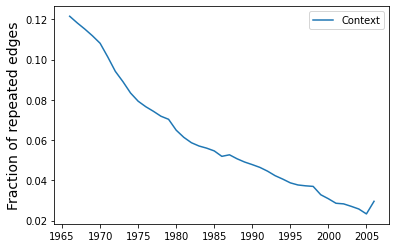

In [24]:
plt.plot(df["time"], df["frac_repeated"], label="Context");
plt.ylabel("Fraction  of repeated edges", fontsize=14);
plt.legend();